In [1]:
import torch 
from dataloader import ECG_Data, prepare_dataset
from resnet_1d import SERes1d
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
if torch.cuda.is_available():
    print("CUDA is available!")
    device = torch.device("cuda")  # Set device to GPU
else:
    print("CUDA is not available. Training on CPU.")
    device = torch.device("cpu")  # Set device to CPU

CUDA is available!


In [3]:
def training_loop(model:torch.nn.Module,
                  optimizer,
                  criterion,
                  train_loader:torch.utils.data.DataLoader,
                  validation_loader:torch.utils.data.DataLoader,
                  epochs:int = 100,
                  save_path:str = None,
                  )-> tuple :
    
    '''
    Training loop for the model
    Documentation TBA
    TODO: Add early stopping
    '''

    train_losses = np.array([])
    train_accuracies = np.array([])
    val_losses = np.array([])
    val_accuracies = np.array([])
    best_acc = 0.0
    for epoch in range(epochs):
        running_loss = 0.0
        train_acc = 0.0
        model.train()
        epoch_start = time.time()
        for data, label in train_loader:
            data = data.to(device)
            label = label.to(device)
            out = model(data)
            loss = criterion(out, label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_acc += torch.sum(torch.sigmoid(out).argmax(dim=1) == label)
            running_loss += loss.item()*data.size(0)
            if save_path is not None:
                if train_acc > best_acc:
                    torch.save(model.state_dict(), save_path)
                    best_acc = train_acc
        epoch_end = time.time()
        train_accuracies = np.append(train_accuracies,train_acc.cpu()/len(train_loader.dataset))
        train_losses = np.append(train_losses, running_loss/len(train_loader.dataset))
        epoch_time = epoch_end - epoch_start
        print(f'Epoch:{epoch}\n-----------Training------------- \n Loss:{train_losses[epoch]}, accuracy:{train_accuracies[epoch]}, epoch time:{epoch_time:.2f}')

        model.eval()
        val_acc = 0.0
        val_running_loss = 0.0
        for data,label in validation_loader:
            data = data.to(device)
            label = label.to(device)
            out = model(data)
            loss = criterion(out, label)
            val_acc += torch.sum(torch.sigmoid(out).argmax(dim=1) == label)
            val_running_loss += loss.item()*data.size(0)
        val_accuracies = np.append(val_accuracies,val_acc.cpu()/len(validation_loader.dataset))
        val_losses = np.append(val_losses, val_running_loss/len(validation_loader.dataset))
        print(f'--------------Validation -------- \n  Loss:{val_losses[epoch]}, accuracy:{val_accuracies[epoch]}')

    return (val_accuracies,val_losses),(train_accuracies,train_losses)

In [4]:
final_data=prepare_dataset(r"ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/ptbxl_database.csv")


    #split zrobiłem sklearnem bo po co się męczyć
ECG_train,ECG_test=train_test_split(final_data,test_size=0.2,random_state=42)

    #inaczej nie działa xd
ECG_train=ECG_train.reset_index()
ECG_test=ECG_test.reset_index()
    #tu ważne żeby podać ścieżkę do folderu z danymi, ale tylko folderu, bo potem to już się samo sklei
train_dataset=ECG_Data(ECG_train, r"./ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/", augmentation_probability=0.5, noise_probability=0.5, noise_level=0.1)
train_loader=torch.utils.data.DataLoader(train_dataset,batch_size=2)
test_dataset=ECG_Data(ECG_test, r"./ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/")
test_loader=torch.utils.data.DataLoader(test_dataset,batch_size=2)

In [5]:
number_of_channels=12
number_of_classes=6
model = SERes1d(number_of_channels,number_of_classes).to(device)

In [9]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
number_of_epochs = 70

In [10]:
val_history,train_history = training_loop(model,optimizer,criterion,train_loader,test_loader,number_of_epochs, save_path="best_SEresnet_model.pth")

Epoch:0
-----------Training------------- 
 Loss:0.5581207965532917, accuracy:0.797392725944519, epoch time:208.97
--------------Validation -------- 
  Loss:0.9365950502568281, accuracy:0.7050987482070923
Epoch:1
-----------Training------------- 
 Loss:0.5341796802677758, accuracy:0.8044564127922058, epoch time:196.75
--------------Validation -------- 
  Loss:0.9871694366986122, accuracy:0.7000459432601929


KeyboardInterrupt: 

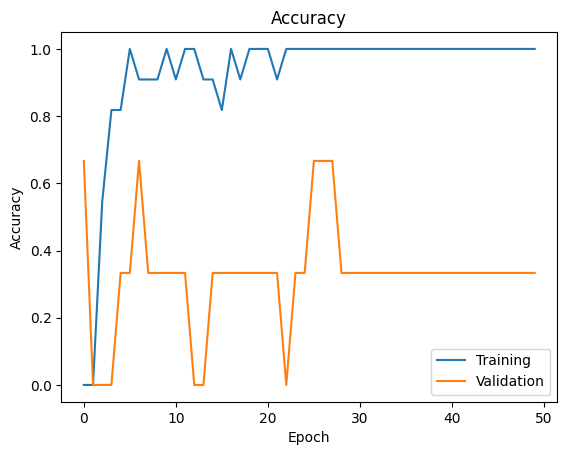

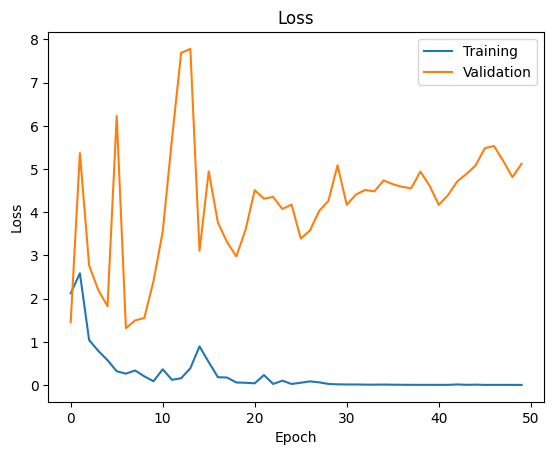

In [ ]:
plt.plot(train_history[0])
plt.plot(val_history[0])
plt.title("Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Training","Validation"])
plt.show()
plt.plot(train_history[1])
plt.plot(val_history[1])
plt.title("Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Training","Validation"])
plt.show()

In [ ]:
model.eval()
accuracy = 0
for data,label in test_loader :
    data = data.to(device)
    out = model(data)
    accuracy += torch.sum(torch.sigmoid(out).argmax(dim=1) == label.to(device))

accuracy = accuracy/ len(test_loader.dataset)
print(accuracy)

tensor(0.3333)
